# An analysis of the State of the Union speeches - Part 2

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve
import nltk
from nltk.stem import PorterStemmer

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [66]:
addresses = pd.read_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    speeches = db['speeches']

Let's double-check that we're getting the full set of speeches:

In [67]:
print(addresses.shape)
print(len(speeches))

(227, 3)
227


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [68]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

We start off by creating a clean word tokenizer that tokenizes speeches, removes stop words and punctuations and turns everything lowercase. 

In [69]:
from nltk.corpus import stopwords
import string

def clean_word_tokenize(doc):
    """custom word tokenizer which removes stop words and punctuation
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    # combine stop words and punctuations
    stop = stopwords.words("english") + list(string.punctuation)
    
    # filter out stop words and punctuation and send each token to lower case
    tokens = [token.lower() for token in nltk.word_tokenize(doc) if token not in stop]

    return(tokens)   #return a list of cleaned words
    

Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [70]:
#We'll create a few helper lists of lists so we don't have to keep rerunning the for loops through the set of speeches

#speeches_cleaned is a list of lists that contains all cleaned words for each speech (not stemmed, not unique)
speeches_cleaned = [clean_word_tokenize(speech) for speech in speeches]

#We'll be using the PorterStemmer to stem our words
stemmer = PorterStemmer()

#speech_words is a list of lists that contains the set of unique, stemmed words for each speech
speech_words = [set(stemmer.stem(word) for word in speech) for speech in speeches_cleaned]

Using our helper lists we add more information about each speech to the addresses dataframe.

In [71]:
#Let's add # of sentences in each speech to addresses  
addresses['n_sent'] = [len(nltk.sent_tokenize(speech)) for speech in speeches]

#Let's add # of total words in each speech to addresses 
addresses['n_words_all'] = [len(nltk.word_tokenize(speech)) for speech in speeches]

#Let's add # of cleaned words in each speech to addresses 
addresses['n_words'] = [len(speech) for speech in speeches_cleaned]

#Let's add # of unique cleaned words in each speech to addresses 
addresses['n_uwords'] = [len(set(speech)) for speech in speeches_cleaned]

#Let's add # of unique stemmed cleaned words in each speech to addresses 
addresses['n_swords'] = [len(speech) for speech in speech_words]

#Finally let's add # characters in each speech to addresses
addresses['n_chars'] = [len(speech) for speech in speeches]                             

Let's look at a summary of these 

In [72]:
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
0,George Washington,State of the Union Address,1790-01-08,24,1178,538,395,356,6753
1,George Washington,State of the Union Address,1790-12-08,40,1515,683,513,463,8455
2,George Washington,State of the Union Address,1791-10-25,60,2487,1136,731,626,14203
3,George Washington,State of the Union Address,1792-11-06,61,2298,1042,682,580,12764
4,George Washington,State of the Union Address,1793-12-03,56,2132,972,714,652,11696


We can quickly obtain summary statistics on each new column to get an idea of each column's distribution amongst all speeches.

In [73]:
pd.options.display.precision = 2
dists = addresses.describe()
dists

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,266.15,8304.19,4047.24,1639.84,1290.51,45473.15
std,178.80,5871.69,2900.51,747.67,508.09,33020.36
min,24.00,1059.00,538.00,395.00,356.00,5649.00
25%,165.00,4396.00,2190.50,1088.50,914.50,23394.50
50%,240.00,6655.00,3388.00,1530.00,1246.00,36677.00
75%,347.50,10055.00,4801.50,1998.50,1552.00,55211.00
max,1343.00,36974.00,21041.00,4282.00,3015.00,218009.00


The standard deviations of sentences and cleaned words is 70% of their means which implies there is a large range of sentence length and word length amongst speeches. Let's actually visualize these distributions to be able to esily compare between the different features. 

(0, 4668.3937873125733)

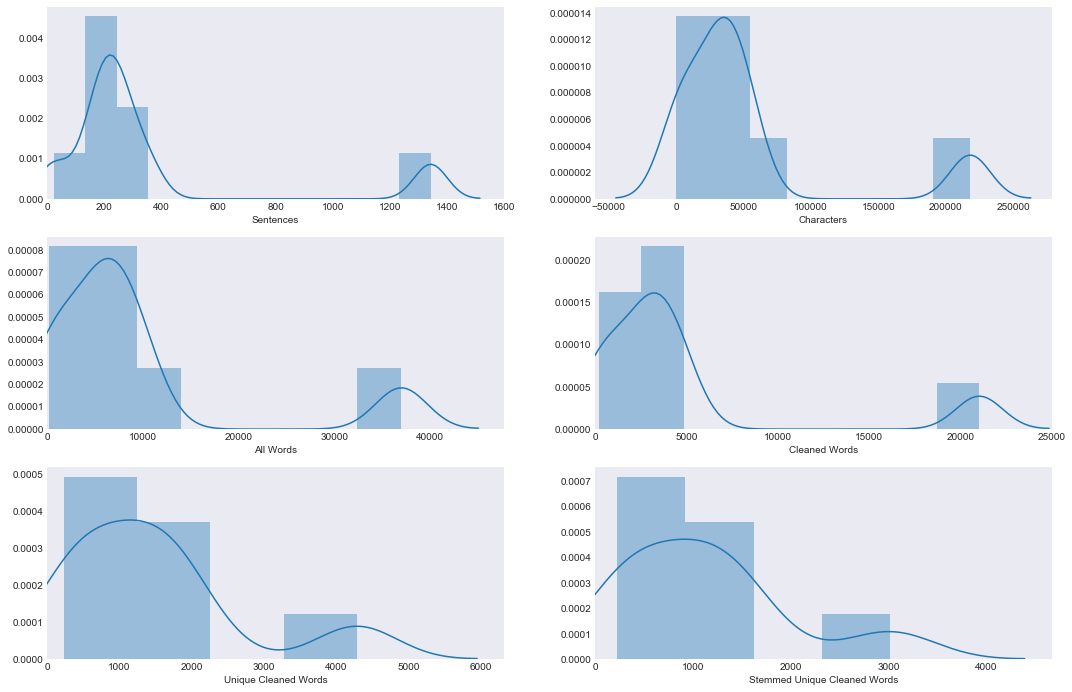

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 12), nrows =3 , ncols = 2)
sns.distplot(dists['n_sent'], ax = ax1[0]);
ax1[0].set_xlabel('Sentences')
ax1[0].set_xlim(0, )

sns.distplot(dists['n_chars'], ax = ax1[1]);
ax1[1].set_xlabel('Characters')
ax2[1].set_xlim(0, )

sns.distplot(dists['n_words_all'], ax = ax2[0]);
ax2[0].set_xlabel('All Words')
ax2[0].set_xlim(0, )

sns.distplot(dists['n_words'], ax = ax2[1]);
ax2[1].set_xlabel('Cleaned Words')
ax2[1].set_xlim(0, 25000)

sns.distplot(dists['n_uwords'], ax = ax3[0]);
ax3[0].set_xlabel('Unique Cleaned Words')
ax3[0].set_xlim(0, )

sns.distplot(dists['n_swords'], ax = ax3[1]);
ax3[1].set_xlabel('Stemmed Unique Cleaned Words')
ax3[1].set_xlim(0, )

All features are bimodal which explains why we are seeing such large standard deviations. Overall it seems like most speeches are fairly short (around 4000 cleaned words) but there are a couple of speeches that are extremely long (close to 20,000 cleaned words). Let's examine if there is change in speech length over time. 

## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

AttributeError: 'Series' object has no attribute 'year'

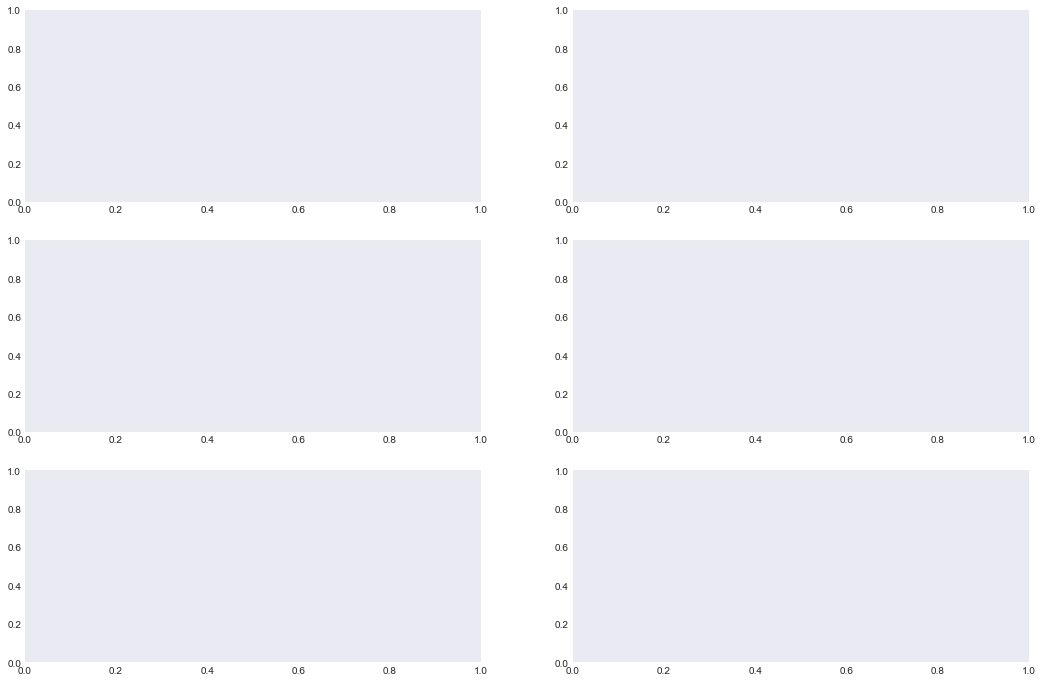

In [75]:
# Use Seaborn to provide a plot such as this, and discuss:
import math

#We'll first extract the years from all the speeches so we can 
years = addresses.date.map(lambda x: x.strftime('%Y'))
years.head()

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18, 12), nrows = 3, ncols = 2)
#sns.distplot(np.log(addresses[['n_sent']]), color = 'b', kde = False, ax = ax1[0]);
sns.tsplot(data = addresses.n_sent, time = addresses.date.year, ax = ax1[0]);


#plt.savefig("fig/speech_changes.png")

Now for the distributions by president

In [ ]:
# YOUR CODE HERE
plt.savefig("fig/speech_characteristics.png");

## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [76]:
addresses.to_hdf('results/df2.h5', 'addresses')

with shelve.open('results/vars2') as db:
    db['speech_words'] = speech_words
    db['speeches_cleaned'] = speeches_cleaned